# Práctica 2: clasificación con **Árbol de Decisión** vs **SVM** — *Dataset `penguins`*

Vamos a comparar dos modelos de Machine Learning usando el dataset penguins de Seaborn.

## Contexto del estudio: campaña científica en la Antártida

Imagina que formas parte de un equipo de biólogos en la Estación Palmer (Antártida).
Durante varias temporadas, el equipo ha medido a pingüinos de tres especies —Adélie, Chinstrap y Gentoo— que viven en tres islas (Biscoe, Dream y Torgersen). El objetivo es entender cómo varían sus características corporales y si esas diferencias permiten identificar la especie automáticamente.

A partir de esas expediciones tenemos el dataset penguins, con medidas sencillas tomadas en el campo.

## Columnas del dataset

Cada fila representa un pingüino y contiene estas variables:

### species
    Especie del pingüino: Adelie, Chinstrap, Gentoo.

### island
    Isla donde se tomó la medición: Biscoe, Dream, Torgersen.

### bill_length_mm
    Longitud del pico en milímetros.

### bill_depth_mm
    Profundidad del pico (grosor) en milímetros.

### flipper_length_mm
    Longitud de la aleta en milímetros.

### body_mass_g
    Masa corporal en gramos.

### sex
    Sexo del individuo: male / female.


**Objetivo didáctico (simple y guiado):**
1. **EDA** breve del dataset `penguins`.
2. **Ejercicio 1 — Árbol de Decisión (binario):** *Adelie vs No‑Adelie* usando dos medidas corporales.
   - Comparar **accuracy** en función de `max_depth`.
   - Elegir el **mejor depth** según TEST.
   - Ver **regiones de decisión** (TRAIN/TEST).
   - Dibujar el **árbol** con `plot_tree`.
   - Calcular **matriz de confusión** (vista didáctica TP/FP/FN/TN) y métricas.
3. **Ejercicio 2 — SVM (multiclase):** predecir **species** con dos medidas.
   - Tres tomas separadas (lineal, RBF, polinómico) para que el alumno **experimente** con `C`, `gamma`, `degree`.
   - Matrices de confusión + `classification_report` y **regiones de decisión**.
4. **Preguntas finales**.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7.2, 4.8)
plt.rcParams['axes.grid'] = True


## 1) Carga de datos y **EDA** rápido
⚠️ **Obligatorio:** usar `sns.pairplot` para visualizar relaciones entre varias variables a la vez. Así como shape, dtypes, describe, value_counts de la librería Pandas

Shape:
(342, 5)
       bill_length_mm  flipper_length_mm  bill_depth_mm  body_mass_g
count      342.000000         342.000000     342.000000   342.000000
mean        43.921930         200.915205      17.151170  4201.754386
std          5.459584          14.061714       1.974793   801.954536
min         32.100000         172.000000      13.100000  2700.000000
25%         39.225000         190.000000      15.600000  3550.000000
50%         44.450000         197.000000      17.300000  4050.000000
75%         48.500000         213.000000      18.700000  4750.000000
max         59.600000         231.000000      21.500000  6300.000000

Conteo por especie:
species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64


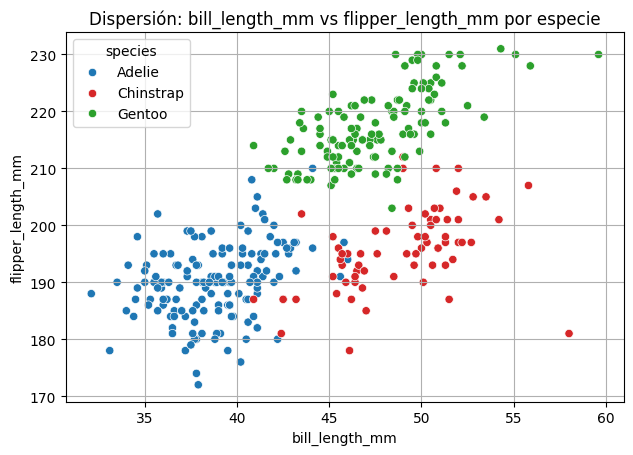


Valores nulos por columna:
species              0
bill_length_mm       0
flipper_length_mm    0
bill_depth_mm        0
body_mass_g          0
dtype: int64


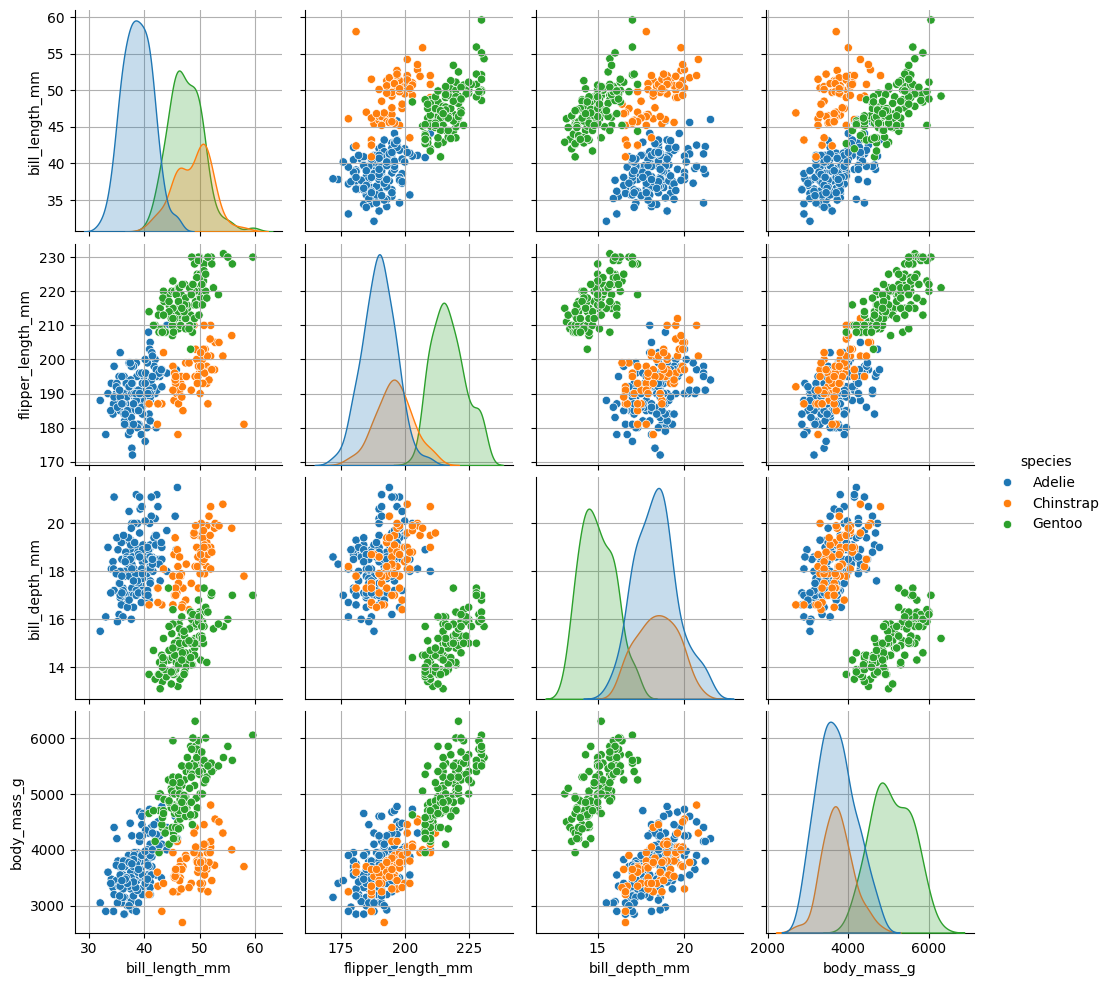

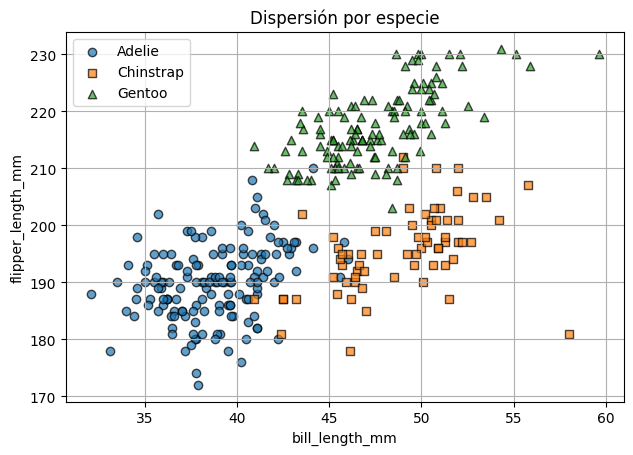

In [3]:
penguins = sns.load_dataset('penguins')
cols_keep = ['species','bill_length_mm','flipper_length_mm','bill_depth_mm','body_mass_g']
df = penguins[cols_keep].dropna().reset_index(drop=True) # Justifica por qué es buena práctica eliminar los valores nulos NA, analiza el EDA entero para concluir esto
# df = penguins[cols_keep]

print("Shape:", )
print(df.shape)

# Descripción numérica (.describe())
print(df.describe())
# Conteo por especie (.value_counts())
print("\nConteo por especie:")
print(df['species'].value_counts())

# Dispersión bill_length vs flipper_length por especie (colores + leyenda)
sns.scatterplot(data=df, x='bill_length_mm', y='flipper_length_mm',
				hue='species',
				palette=['#1f77b4','#d62728','#2ca02c'])
plt.xlabel('bill_length_mm'); plt.ylabel('flipper_length_mm')
plt.title('Dispersión: bill_length_mm vs flipper_length_mm por especie')
plt.legend(title='species'); plt.show()

# isna()
print("\nValores nulos por columna:")
print(df.isna().sum())

sns.pairplot(df, vars=['bill_length_mm','flipper_length_mm','bill_depth_mm','body_mass_g'], hue='species')
plt.show()


####### No tocar
species = df['species'].unique()
markers = ['o','s','^']
plt.figure()
for sp, mk in zip(species, markers):
    mask = df['species']==sp
    plt.scatter(df.loc[mask,'bill_length_mm'],
                df.loc[mask,'flipper_length_mm'],
                marker=mk, alpha=0.7, label=sp, edgecolor='k')
plt.xlabel('bill_length_mm'); plt.ylabel('flipper_length_mm')
plt.title('Dispersión por especie')
plt.legend()
plt.show()



## 2) **Ejercicio 1 — Árbol de Decisión (binario)** (70/30)
**Target:** `Adelie` (=1) vs `No‑Adelie` (=0)  
**Features:** elige **2** medidas corporales.


In [4]:
# Elige las variables (cámbialas libremente si lo ves necesario):
FEAT_X = 'bill_length_mm'
FEAT_Y = 'flipper_length_mm'

X = df[[FEAT_X, FEAT_Y]].values
y = (df['species'] == 'Adelie').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

print("Shapes — X_train/X_test:", X_train.shape, X_test.shape)


Shapes — X_train/X_test: (239, 2) (103, 2)


### 2.1 Precisión según **max_depth**

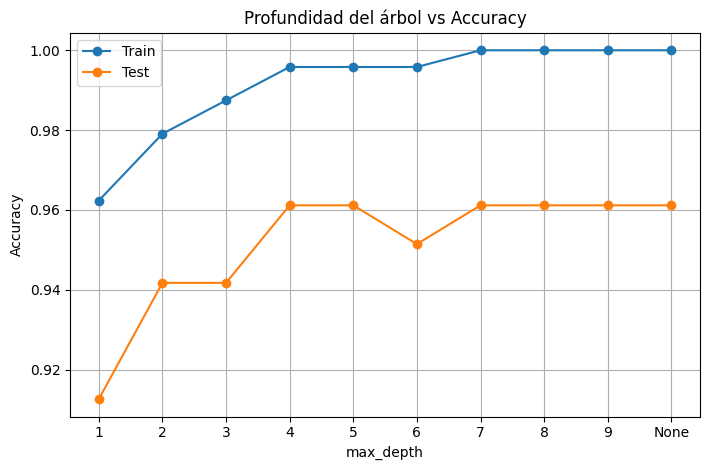

In [5]:
#Establece las profundidades que quieras probar en el árbol
depths = [1,2,3,4,5,6,7,8,9,None]
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(random_state=42, max_depth=d)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

x_labels = [str(d) if d is not None else 'None' for d in depths]

plt.figure()
plt.plot(range(len(depths)), train_scores, marker='o', label='Train')
plt.plot(range(len(depths)), test_scores, marker='o', label='Test')
plt.xticks(range(len(depths)), x_labels)
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Profundidad del árbol vs Accuracy'); plt.legend(); plt.tight_layout(); plt.show()



### 2.2 **Regiones de decisión**

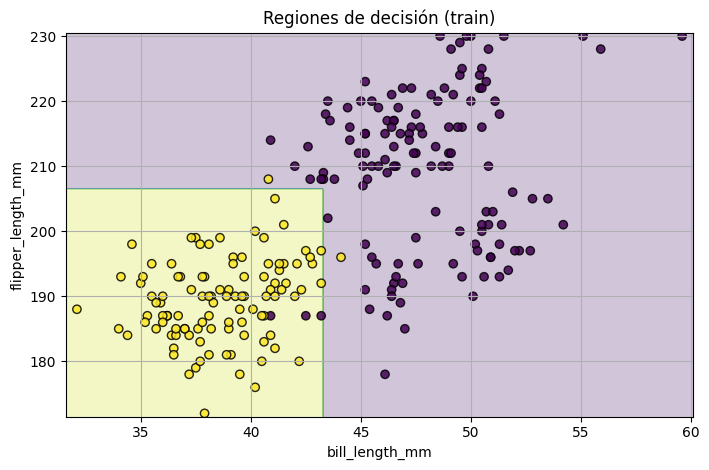

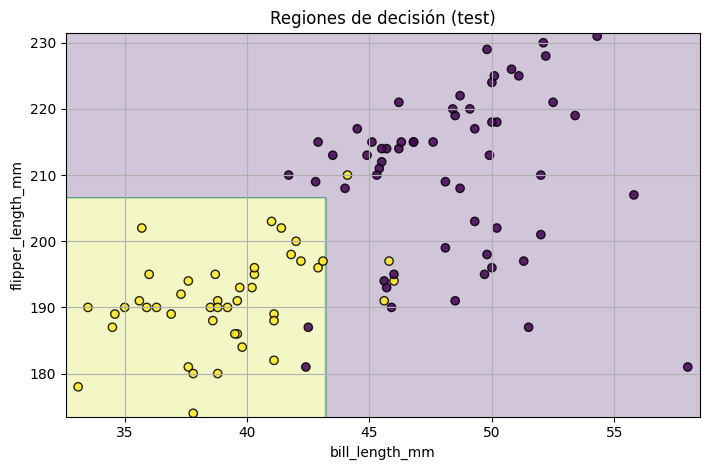

In [45]:

def plot_decision_regions_2d(model, X, y, title='Decision regions'):
    x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', alpha=0.85)
    plt.xlabel(FEAT_X); plt.ylabel(FEAT_Y); plt.title(title)
    plt.tight_layout(); plt.show()
    
best_tree = DecisionTreeClassifier(random_state=42, max_depth=2)
best_tree.fit(X_train, y_train)

plot_decision_regions_2d(best_tree, X_train, y_train, title='Regiones de decisión (train)')
plot_decision_regions_2d(best_tree, X_test,  y_test,  title='Regiones de decisión (test)')


### 2.3 **Árbol** con `plot_tree`

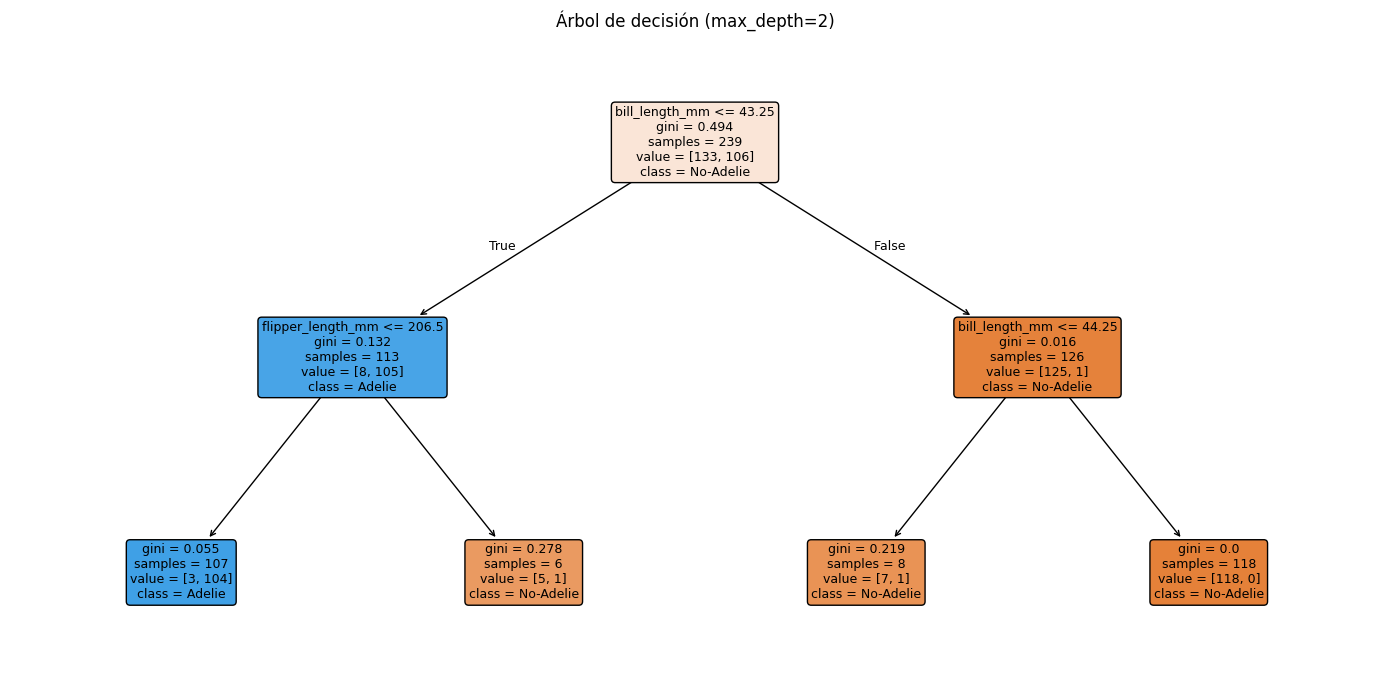

In [ ]:
#Siendo best_depth la variable con mejor profundidad, dibuja el árbol. La variable corresponde a la profundidad del apartado 2.1
best_depth = 3
best_tree = DecisionTreeClassifier(random_state=42, max_depth=best_depth).fit(X_train, y_train)

plt.figure(figsize=(14,7))
plot_tree(best_tree,
          feature_names=[FEAT_X, FEAT_Y],
          class_names=['No-Adelie','Adelie'],
          filled=True, rounded=True, fontsize=9)
plt.title(f'Árbol de decisión (max_depth={best_depth})')
plt.tight_layout(); plt.show()


### 2.4 **Matriz de Confusión** métricas

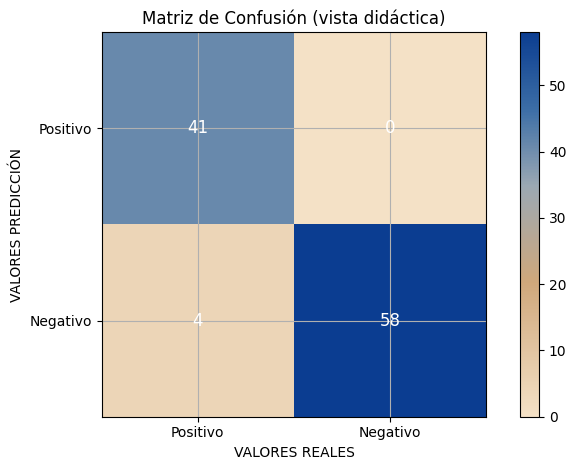

TP, TN, FP, FN = 41 58 0 4
Accuracy : 0.961
Precision: 1.000
Recall   : 0.911
F1-score : 0.953

Informe de clasificación (TEST):

              precision    recall  f1-score   support

   No-Adelie       0.94      1.00      0.97        58
      Adelie       1.00      0.91      0.95        45

    accuracy                           0.96       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.96      0.96      0.96       103



In [33]:

y_pred_best = best_tree.predict(X_test)
cm_official = confusion_matrix(y_test, y_pred_best, labels=[1,0])
TP, FN, FP, TN = cm_official.ravel()

cm_view = np.array([[TP, FP],
                    [FN, TN]])

brown_to_blue = LinearSegmentedColormap.from_list(
    "brown_to_blue",
    [
        (0.00, "#F4E1C6"),
        (0.35, "#CFA77B"),
        (0.60, "#9BA8B3"),
        (0.80, "#3C6EA6"),
        (1.00, "#0B3D91"),
    ],
    N=256
)

fig, ax = plt.subplots()
im = ax.imshow(cm_view, cmap=brown_to_blue)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Positivo','Negativo'])
ax.set_yticklabels(['Positivo','Negativo'])
ax.set_xlabel('VALORES REALES'); ax.set_ylabel('VALORES PREDICCIÓN')
plt.colorbar(im, ax=ax)

for i in range(2):
    for j in range(2):
        ax.text(j, i, int(cm_view[i, j]), ha='center', va='center', color='white', fontsize=12)

plt.title('Matriz de Confusión (vista didáctica)')
plt.tight_layout(); plt.show()

acc  = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best, zero_division=0)
rec  = recall_score(y_test, y_pred_best, zero_division=0)
f1   = f1_score(y_test, y_pred_best, zero_division=0)

print(f"TP, TN, FP, FN = {TP} {TN} {FP} {FN}")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print('\nInforme de clasificación (TEST):\n')
print(classification_report(y_test, y_pred_best, digits=2, target_names=['No-Adelie','Adelie']))



## 3) **Ejercicio 2 — SVM (multiclase)**
Target: `species` (Adelie / Chinstrap / Gentoo).  
Usamos las mismas features para comparar.


In [25]:

Xs = df[[FEAT_X, FEAT_Y]].values
ys = df['species'].values

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(
    Xs, ys, test_size=0.3, random_state=RANDOM_STATE, stratify=ys
)

###########
# No tocar nada
def plot_cm(cm, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    ax.set_xlabel('Predicción'); ax.set_ylabel('Real')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
    plt.colorbar(im, ax=ax)
    plt.title(title); plt.tight_layout(); plt.show()

def plot_regions_multiclass(model, X, y, title):
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z_lab = model.predict(grid).reshape(xx.shape)
    classes = model.classes_
    mapping = {cls:i for i,cls in enumerate(classes)}
    Z = np.vectorize(mapping.get)(Z_lab)
    y_num = np.vectorize(mapping.get)(y)
    cmap = ListedColormap(['#1f77b4', '#d62728', '#2ca02c'])
    plt.figure(figsize=(6.5,5))
    plt.contourf(xx, yy, Z, levels=np.arange(len(classes)+1)-0.5, cmap=cmap, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y_num, cmap=cmap, edgecolor='k', alpha=0.9)
    plt.xlabel(FEAT_X); plt.ylabel(FEAT_Y)
    plt.title(title + f"  (clases: {classes.tolist()})")
    plt.tight_layout(); plt.show()


### 3.1 **SVM lineal** (punto de partida)

=== SVM lineal ===
Accuracy (train/test): 0.946 / 0.981


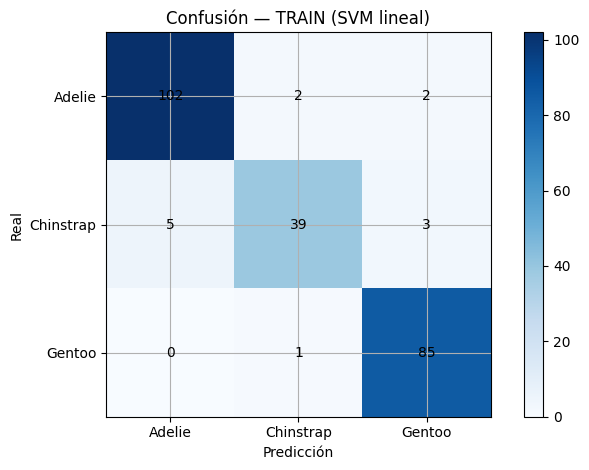

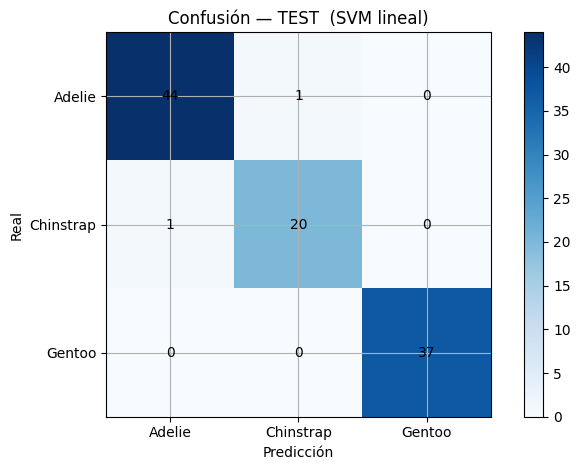

Classification report (TEST):
               precision    recall  f1-score   support

      Adelie      0.978     0.978     0.978        45
   Chinstrap      0.952     0.952     0.952        21
      Gentoo      1.000     1.000     1.000        37

    accuracy                          0.981       103
   macro avg      0.977     0.977     0.977       103
weighted avg      0.981     0.981     0.981       103



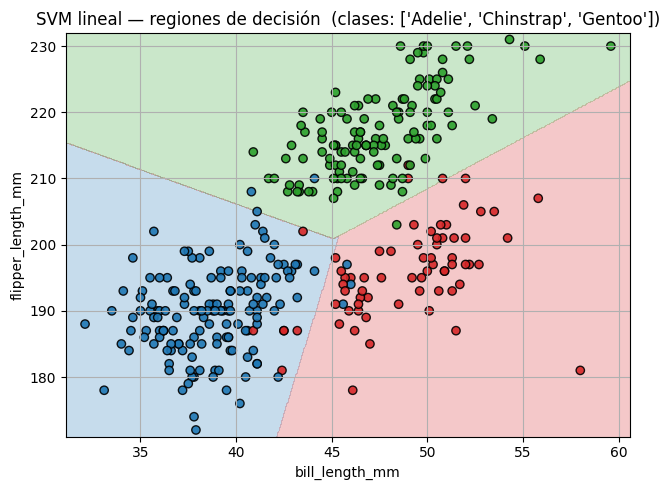

In [26]:
### Monta la Pipeline del SVM Lineal
svm_lin = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE))
])

svm_lin.fit(Xs_tr, ys_tr)
pred_tr = svm_lin.predict(Xs_tr)
pred_te = svm_lin.predict(Xs_te)

print("=== SVM lineal ===")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_lin.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_lin.classes_)
plot_cm(cm_tr, svm_lin.classes_, "Confusión — TRAIN (SVM lineal)")
plot_cm(cm_te, svm_lin.classes_, "Confusión — TEST  (SVM lineal)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_lin, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM lineal — regiones de decisión")


### 3.2 **SVM RBF** (curvatura con `gamma`)


=== SVM RBF ===
Accuracy (train/test): 0.996 / 0.922


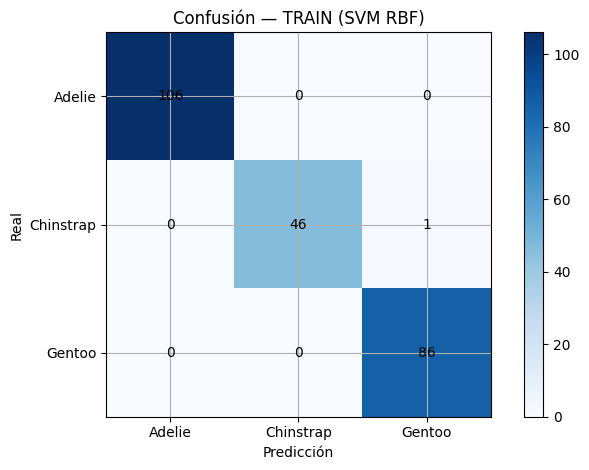

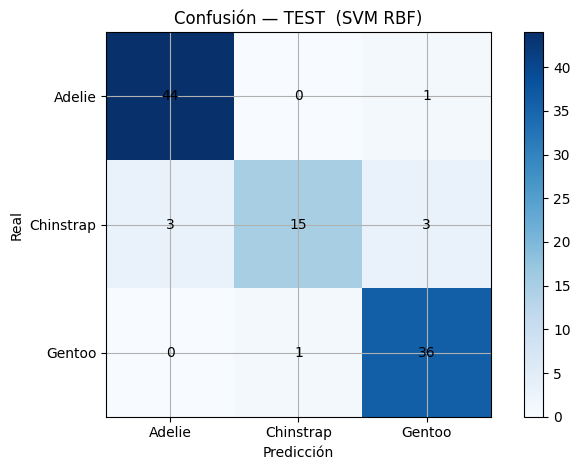

Classification report (TEST):
               precision    recall  f1-score   support

      Adelie      0.936     0.978     0.957        45
   Chinstrap      0.938     0.714     0.811        21
      Gentoo      0.900     0.973     0.935        37

    accuracy                          0.922       103
   macro avg      0.925     0.888     0.901       103
weighted avg      0.923     0.922     0.919       103



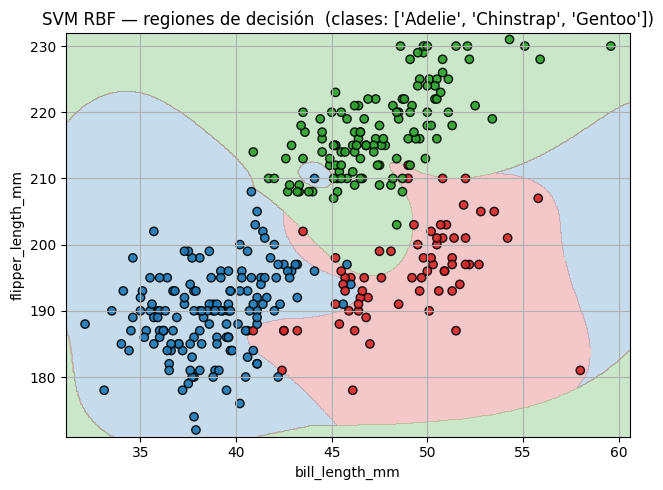

In [49]:
### Monta la Pipeline del SVM con Kernel RBF
svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='rbf', C=100000, gamma=1, random_state=RANDOM_STATE))
])

svm_rbf.fit(Xs_tr, ys_tr)
pred_tr = svm_rbf.predict(Xs_tr)
pred_te = svm_rbf.predict(Xs_te)

print("\n=== SVM RBF ===")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_rbf.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_rbf.classes_)
plot_cm(cm_tr, svm_rbf.classes_, "Confusión — TRAIN (SVM RBF)")
plot_cm(cm_te, svm_rbf.classes_, "Confusión — TEST  (SVM RBF)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_rbf, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM RBF — regiones de decisión")


### 3.3 **SVM polinómico** (control con `degree`)


=== SVM polinómico ===
Accuracy (train/test): 0.921 / 0.893


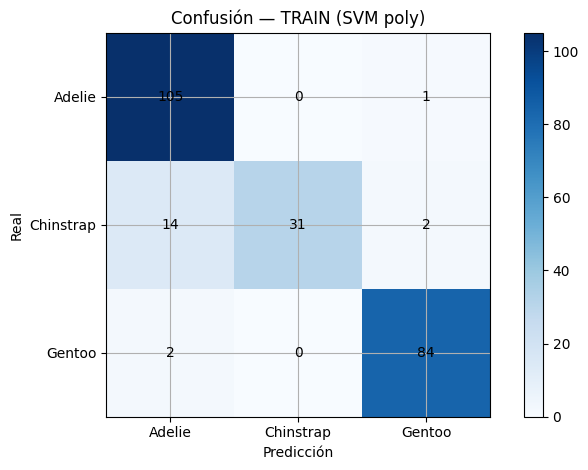

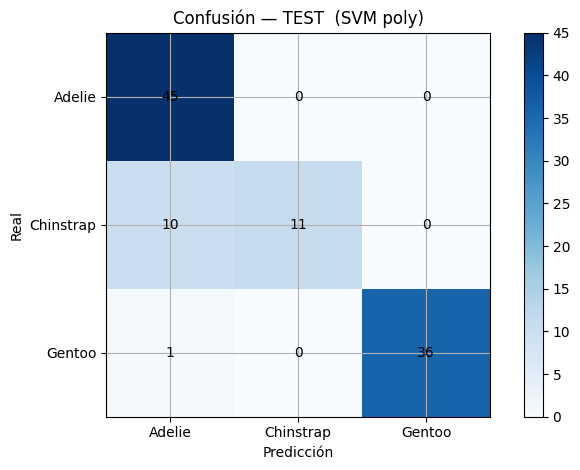

Classification report (TEST):
               precision    recall  f1-score   support

      Adelie      0.804     1.000     0.891        45
   Chinstrap      1.000     0.524     0.688        21
      Gentoo      1.000     0.973     0.986        37

    accuracy                          0.893       103
   macro avg      0.935     0.832     0.855       103
weighted avg      0.914     0.893     0.884       103



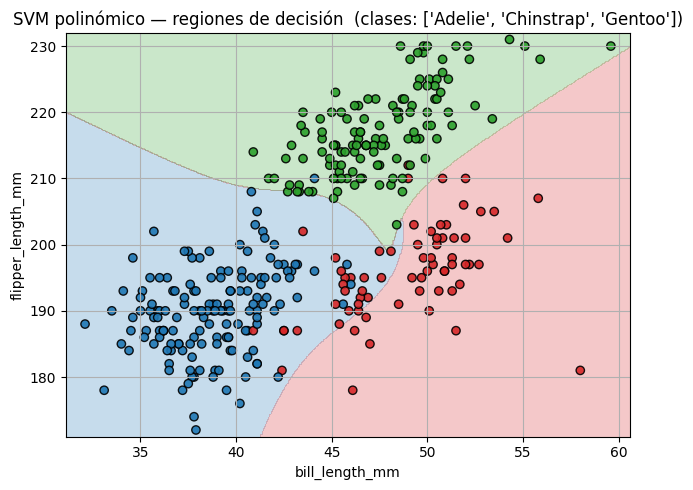

In [29]:
### Monta la Pipeline del SVM con Kernel Poly
svm_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='poly', degree=3, C=1.0, random_state=RANDOM_STATE))
])

svm_poly.fit(Xs_tr, ys_tr)
pred_tr = svm_poly.predict(Xs_tr)
pred_te = svm_poly.predict(Xs_te)

print("\n=== SVM polinómico ===")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_poly.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_poly.classes_)
plot_cm(cm_tr, svm_poly.classes_, "Confusión — TRAIN (SVM poly)")
plot_cm(cm_te, svm_poly.classes_, "Confusión — TEST  (SVM poly)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_poly, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM polinómico — regiones de decisión")



## 4) Preguntas para entregar

1. ¿Qué `max_depth` ofrece mejor **accuracy de TEST** en el árbol? ¿Por qué no conviene usar `None` por defecto?
2. Mira la frontera del árbol en TEST. ¿Dónde ves **sobreajuste**?
3. Compara las **matrices de confusión** del árbol y del SVM lineal: ¿cuál equilibra mejor aciertos en cada clase?
4. En SVM **RBF**, modifica `gamma` y `C` (0.1, 1, 10): ¿cómo cambia la frontera y el accuracy de TEST? Explica el rol de cada hiperparámetro.
5. En SVM **polinómico**, prueba `degree=2` y `degree=4`. ¿Mejora el test? ¿Qué efecto visual observas al aumentar el grado?
